# Tail Latency Curve

## 1. Copy latency hdr files to this machine

```console
$ rsync -azR --no-i-r -h --info=progress2 squirrel.moma:/home/wenyuz/./MMTk-Dev/evaluation/results/log/lxr-latency-bear-2023-12-21-Thu-114935 /home/wenyuz
```

## 2. Imports and configs

In [2]:
from hdrh.histogram import HdrHistogram
import seaborn as sns
import pandas
from matplotlib import pyplot as plt
import os.path
from enum import Enum
import matplotlib as mpl
from typing import *

In [3]:
class LatencyType(Enum):
    METERED = 'metered'
    SIMPLE = 'simple'

LATENCY_TYPE = LatencyType.METERED

RUNID = ''
RUNID1 = 'lxr-latency-boar-2023-12-21-Thu-115051'
RUNIDS = [RUNID1]

HFAC = 1989
HEAP = {
    'lusearch': 34,
    'cassandra': 229,
    'h2':  1347,
    'kafra': 400,
    'spring': 90,
    'tomcat': 42,
    'tradebeans': 209,
    'tradesoap': 169,
}
DACAPO = 'dacapochopin'


SAVE_FILE = 'pdf'
# SAVE_FILE = 'jpg'
# SAVE_FILE = None


DATA = {
    'G1': [
        RUNID1 + '/{bench}.{hfac}.{heap}.jdk-lxr.g1.common3.hs.latency.{dacapo}',
    ],
    'Shen.': [
        RUNID1 + '/{bench}.{hfac}.{heap}.jdk-lxr.shenandoah.common3.hs.latency.{dacapo}',
    ],
    'LXR': [
        RUNID1 + '/{bench}.{hfac}.{heap}.jdk-lxr.lxr.common3.tph.latency.{dacapo}',
    ],
    'ZGC': [
        RUNID1 + '/{bench}.{hfac}.{heap}.jdk-lxr.z.common3.hs.latency.{dacapo}',
    ],
}
MAX_INVOCATIONS = 40
MIN_LATENCY_USEC = 1
MAX_LATENCY_USEC = 1000 * 1000 # 1 sec
LATENCY_SIGNIFICANT_DIGITS = 5

LABEL_FONT_SIZE = 60
LEGEND_FONT_SIZE = 60
TICK_FONT_SIZE = 50

In [3]:

# plt.rcParams["font.family"] = "Linux Biolinum"

from pathlib import Path
import polars as pl


plt.rc('pdf',fonttype = 42)
plt.rc('ps',fonttype = 42)


def parse_latency(folder: Path):
    LOWEST = 1
    HIGHEST = 60000000
    SIGNIFICANT = 4
    # folder = Path("../data/dacapo-pldi-2024-latency-vole-2023-11-12-Sun-235729")
    records = []
    # print(folder)
    folders = list(folder.glob("*"))
    # print(folders)
    for i, child in enumerate(folders, start=1):
        print("{}/{}".format(i, len(folders)))
        if not child.is_dir():
            continue
        parts = child.name.split(".")
        # print(parts)
        gc = parts[4]
        if gc == "Z" and parts[6] == "zgc_gen":
            gc = "GenZ"
        row = dict(
            _benchmark=parts[0],
            _hfac=int(parts[1]),
            _heap=int(parts[2]),
            _hotspot_gc=gc,
            _invocation=parts[-1],
        )
        for hdr in child.glob("*4.hdr"):
            # print(hdr)
            parts = hdr.stem.split("-")
            latency_type = parts[3]
            iteration = int(parts[4])
            with hdr.open("r") as fd:
                hist_raw = fd.read().split(",")[3]
                hist = HdrHistogram.decode(hist_raw)
                for i in hist.get_percentile_iterator(5):
                    records.append(
                        dict(
                            **row,
                            value=i.value_iterated_to,
                            percentile=i.percentile_level_iterated_to / 100,
                            _latency_type=latency_type,
                            _iteration=iteration
                        )
                    )
    hdrh_df = pl.DataFrame(records)
    # print(hdrh_df)
    return hdrh_df.with_columns((1 / (1 - pl.col("percentile"))).alias("reciprocal"))

result = parse_latency(Path("/home/wenyuz/MMTk-Dev/evaluation/results/log/lxr-latency-boar-2023-12-21-Thu-115051"))
print(result)
# def load_data(invocation: int, latency_type: LatencyType, folder: str):
#     path = os.path.realpath(os.path.expanduser('{}.{}/dacapo-latency-usec-{}.csv'.format(folder, invocation, latency_type.value)))
#     if not os.path.isfile(path):
#         return None
#     df =  pandas.read_csv(path, names=["start", "end"])
#     try:
#         df["latency"] = df["end"] - df["start"]
#     except Exception as e:
#         print(path)
#         raise  e
#     return df

# def load_data_and_plot(bench, data: Optional[Dict[str, Union[str, List[str]]]] = None, invocations = MAX_INVOCATIONS, save = SAVE_FILE, latency_type: LatencyType = LATENCY_TYPE, legend: Union[str, bool] = True, max_percentile='99.999'):
#     assert bench in HEAP
#     print(f'[{bench}] Loading...')
#     histograms = {}
#     # Clean up inputs
#     if data is None:
#         data = { k: v for k, v in DATA.items() }
#     for gc in data.keys():
#         if isinstance(data[gc], str):
#             data[gc] = [ data[gc] ]
#         data[gc] = [
#             f'~/MMTk-Dev/evaluation/results/log/{x}'.format(runid=RUNID, bench=bench, hfac=HFAC, heap=HEAP[bench], dacapo=DACAPO)
#             for x in data[gc]
#         ]
#     data: Dict[str, List[str]]
#     # Load data
#     for gc, logs in data.items():
#         histograms[gc] = []
#         for folder in logs:
#             for i in range(invocations):
#                 loaded_data = load_data(i, latency_type, folder)
#                 if loaded_data is None:
#                     continue
#                 histogram = HdrHistogram(MIN_LATENCY_USEC, MAX_LATENCY_USEC, LATENCY_SIGNIFICANT_DIGITS)
#                 latencies = loaded_data["latency"]
#                 for l in latencies:
#                     histogram.record_value(l)
#                 histograms[gc].append(histogram)
#         if len(histograms[gc]) == 0:
#             histogram = HdrHistogram(MIN_LATENCY_USEC, MAX_LATENCY_USEC, LATENCY_SIGNIFICANT_DIGITS)
#             histogram.record_value(0)
#             histograms[gc].append(histogram)
#     # Process data
#     print(f'[{bench}] Processing...')
#     percentile_list = []
#     for gc, hists in histograms.items():
#         for j, histogram in enumerate(hists):
#             for i in histogram.get_percentile_iterator(5):
#                 percentile_list.append({"GC": gc, "inv": j, "value": i.value_iterated_to, "percentile": i.percentile_level_iterated_to / 100})
#     percentile_df = pandas.DataFrame(percentile_list)
#     percentile_df["other"] = 1 / (1 - percentile_df["percentile"])
#     # Plot curves
#     print(f'[{bench}] Plotting...')
#     fig, ax = plt.subplots(1,1,figsize=(16,12))
#     # fig.suptitle(f'{bench} {latency_type} latency')
#     sns.color_palette()
#     # colors = ['green', 'blue', 'orange', 'red'][:len(gcs)]
#     # print(f'{gcs} {colors}')
#     sns.lineplot(data=percentile_df, x="other", y="value", hue="GC")
#     # sns.lineplot(data=percentile_df, x="other", y="value", hue="GC")
#     ax.set_xscale('log')
#     ax.set_xlabel('Percentile', fontsize=LABEL_FONT_SIZE, labelpad=12)
#     ax.set_ylabel('Latency (msec)', fontsize=LABEL_FONT_SIZE, labelpad=12)
#     labels = ['0', '90', '99', '99.9', '99.99', '99.999', '99.9999']
#     ax.set_xticks([1, 10, 100, 1000, 10000, 100000, 1000000][:labels.index(max_percentile) + 1])
#     ax.set_xticklabels(labels[:labels.index(max_percentile) + 1], fontsize=TICK_FONT_SIZE)
#     # ax.set_xticks([1, 10, 100, 1000, 10000, 100000])
#     # ax.set_xticklabels(['0', '90', '99', '99.9', '99.99', '99.999'], fontsize=TICK_FONT_SIZE)
#     plt.yticks(fontsize=TICK_FONT_SIZE)
#     ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(lambda x, pos: f'{int(x / 1000)}'.format(x)))
#     handles, labels = plt.gca().get_legend_handles_labels()
#     order = [0,1,3,2]
#     if legend == False:
#         plt.legend([], [], frameon=False)
#     elif legend == True:
#         plt.legend([handles[i] for i in order], [labels[i] for i in order],  fontsize=LEGEND_FONT_SIZE)
#     else:
#         plt.legend([handles[i] for i in order], [labels[i] for i in order], fontsize=LEGEND_FONT_SIZE, loc=legend)
#     plt.tight_layout()

#     if save is not None:
#         print(f'[{bench}] Save to latency-{bench}.{save}')
#         plt.savefig(f'latency-{bench}.{save}', bbox_inches='tight')

1/1057
2/1057
3/1057
4/1057
5/1057
6/1057
7/1057
8/1057
9/1057
10/1057
11/1057
12/1057
13/1057
14/1057
15/1057
16/1057
17/1057
18/1057
19/1057
20/1057
21/1057
22/1057
23/1057
24/1057
25/1057
26/1057
27/1057
28/1057
29/1057
30/1057
31/1057
32/1057
33/1057
34/1057
35/1057
36/1057
37/1057
38/1057
39/1057
40/1057
41/1057
42/1057
43/1057
44/1057
45/1057
46/1057
47/1057
48/1057
49/1057
50/1057
51/1057
52/1057
53/1057
54/1057
55/1057
56/1057
57/1057
58/1057
59/1057
60/1057
61/1057
62/1057
63/1057
64/1057
65/1057
66/1057
67/1057
68/1057
69/1057
70/1057
71/1057
72/1057
73/1057
74/1057
75/1057
76/1057
77/1057
78/1057
79/1057
80/1057
81/1057
82/1057
83/1057
84/1057
85/1057
86/1057
87/1057
88/1057
89/1057
90/1057
91/1057
92/1057
93/1057
94/1057
95/1057
96/1057
97/1057
98/1057
99/1057
100/1057
101/1057
102/1057
103/1057
104/1057
105/1057
106/1057
107/1057
108/1057
109/1057
110/1057
111/1057
112/1057
113/1057
114/1057
115/1057
116/1057
117/1057
118/1057
119/1057
120/1057
121/1057
122/1057
123/1057
1

In [ ]:
latency_sns_common = {
    "hue_order": ["Serial", "Parallel", "G1", "Shenandoah", "Z", "GenZ"],
    "palette": ["#000000", "#8e00ff", "#417be4", "#ff8e00", "#ff0000", "#db4b93"],
    "hue": "_hotspot_gc",
}


def latency_legend_annotate(ax: matplotlib.axes.Axes, use_year: bool, legend_kwargs):
    if use_year:
        renaming_map = dict(
            zip(
                ["Serial", "Parallel", "G1", "Shenandoah", "Z", "GenZ"],
                [
                    "1998 Serial",
                    "2005 Parallel",
                    "2009 G1",
                    "2014 Shen.",
                    "2018 ZGC",
                    "2023 GenZGC",
                ],
            )
        )
    else:
        renaming_map = dict(
            zip(
                ["Serial", "Parallel", "G1", "Shenandoah", "Z", "GenZ"],
                [
                    "Serial",
                    "Parallel",
                    "G1",
                    "Shen.",
                    "ZGC",
                    "GenZGC",
                ],
            )
        )
    lines = []
    labels = []
    for line in list(ax.get_lines()):
        if line.get_label() in renaming_map:
            lines.append(line)
            labels.append(renaming_map[line.get_label()])
    ax.legend(lines, labels, **legend_kwargs)


def draw_latency():
    lf = pl.scan_parquet(
        "../data/dacapo-pldi-2024-latency-vole-2023-11-12-Sun-235729/parsed_latency.parquet"
    )
    df = (
        lf.filter(pl.col("_iteration") == 4, pl.col("reciprocal").is_finite())
        .with_columns(pl.col("value") / 1000000)  # ns -> ms
        .collect()
    )
    for (bm, hfac, latency_type), bm_df in df.group_by(
        "_benchmark", "_hfac", "_latency_type"
    ):
        fig, ax = plt.subplots(figsize=(5, 3))
        sns.lineplot(data=bm_df, x="reciprocal", y="value", ax=ax, **latency_sns_common)
        ax.set_xscale("log")
        ax.set_yscale("log")
        xticks = [1, 10, 100, 1000, 10000, 100000, 1000000]
        xlabels = ["0", "90", "99", "99.9", "99.99", "99.999", "99.9999"]
        max_x = bm_df.select("reciprocal").max().item()
        for i, xtick in enumerate(xticks):
            if xtick > max_x:
                xticks = xticks[: i + 1]
                xlabels = xlabels[: i + 1]
        ax.set_xticks(xticks)
        ax.set_xticklabels(xlabels)
        ax.set_xlabel("Percentile")
        ax.set_ylabel("Request latency (ms)")
        round_off_axes(ax)
        latency_legend_annotate(
            ax, True, legend_kwargs={"frameon": False, "fontsize": 11, "loc": "best"}
        )
        fig.savefig(
            "../figs/latency/{}_{}_{}.pdf".format(bm, latency_type, hfac),
            bbox_inches="tight",
        )
        latency_legend_annotate(
            ax, False, legend_kwargs={"frameon": False, "fontsize": 11, "loc": "best"}
        )
        fig.savefig(
            "../figs/latency/{}_{}_{}_noyear.pdf".format(bm, latency_type, hfac),
            bbox_inches="tight",
        )
        ax.get_legend().remove()
        fig.savefig(
            "../figs/latency/{}_{}_{}_nolegend.pdf".format(bm, latency_type, hfac),
            bbox_inches="tight",
        )
        plt.close()


findfont: Font family 'Linux Biolinum' not found.
findfont: Font family 'Linux Biolinum' not found.
findfont: Font family 'Linux Biolinum' not found.
findfont: Font family 'Linux Biolinum' not found.
findfont: Font family 'Linux Biolinum' not found.
findfont: Font family 'Linux Biolinum' not found.
findfont: Font family 'Linux Biolinum' not found.
findfont: Font family 'Linux Biolinum' not found.
findfont: Font family 'Linux Biolinum' not found.
findfont: Font family 'Linux Biolinum' not found.
findfont: Font family 'Linux Biolinum' not found.
findfont: Font family 'Linux Biolinum' not found.
findfont: Font family 'Linux Biolinum' not found.
findfont: Font family 'Linux Biolinum' not found.
findfont: Font family 'Linux Biolinum' not found.
findfont: Font family 'Linux Biolinum' not found.
findfont: Font family 'Linux Biolinum' not found.
findfont: Font family 'Linux Biolinum' not found.
findfont: Font family 'Linux Biolinum' not found.
findfont: Font family 'Linux Biolinum' not found.


[lusearch] Loading...
[lusearch] Processing...
[lusearch] Plotting...
[lusearch] Save to latency-lusearch.pdf


findfont: Font family 'Linux Biolinum' not found.
findfont: Font family 'Linux Biolinum' not found.
findfont: Font family 'Linux Biolinum' not found.
findfont: Font family 'Linux Biolinum' not found.
findfont: Font family 'Linux Biolinum' not found.
findfont: Font family 'Linux Biolinum' not found.
findfont: Font family 'Linux Biolinum' not found.
findfont: Font family 'Linux Biolinum' not found.
findfont: Font family 'Linux Biolinum' not found.
findfont: Font family 'Linux Biolinum' not found.
findfont: Font family 'Linux Biolinum' not found.
findfont: Font family 'Linux Biolinum' not found.
findfont: Font family 'Linux Biolinum' not found.
findfont: Font family 'Linux Biolinum' not found.
findfont: Font family 'Linux Biolinum' not found.
findfont: Font family 'Linux Biolinum' not found.
findfont: Font family 'Linux Biolinum' not found.
findfont: Font family 'Linux Biolinum' not found.
findfont: Font family 'Linux Biolinum' not found.
findfont: Font family 'Linux Biolinum' not found.


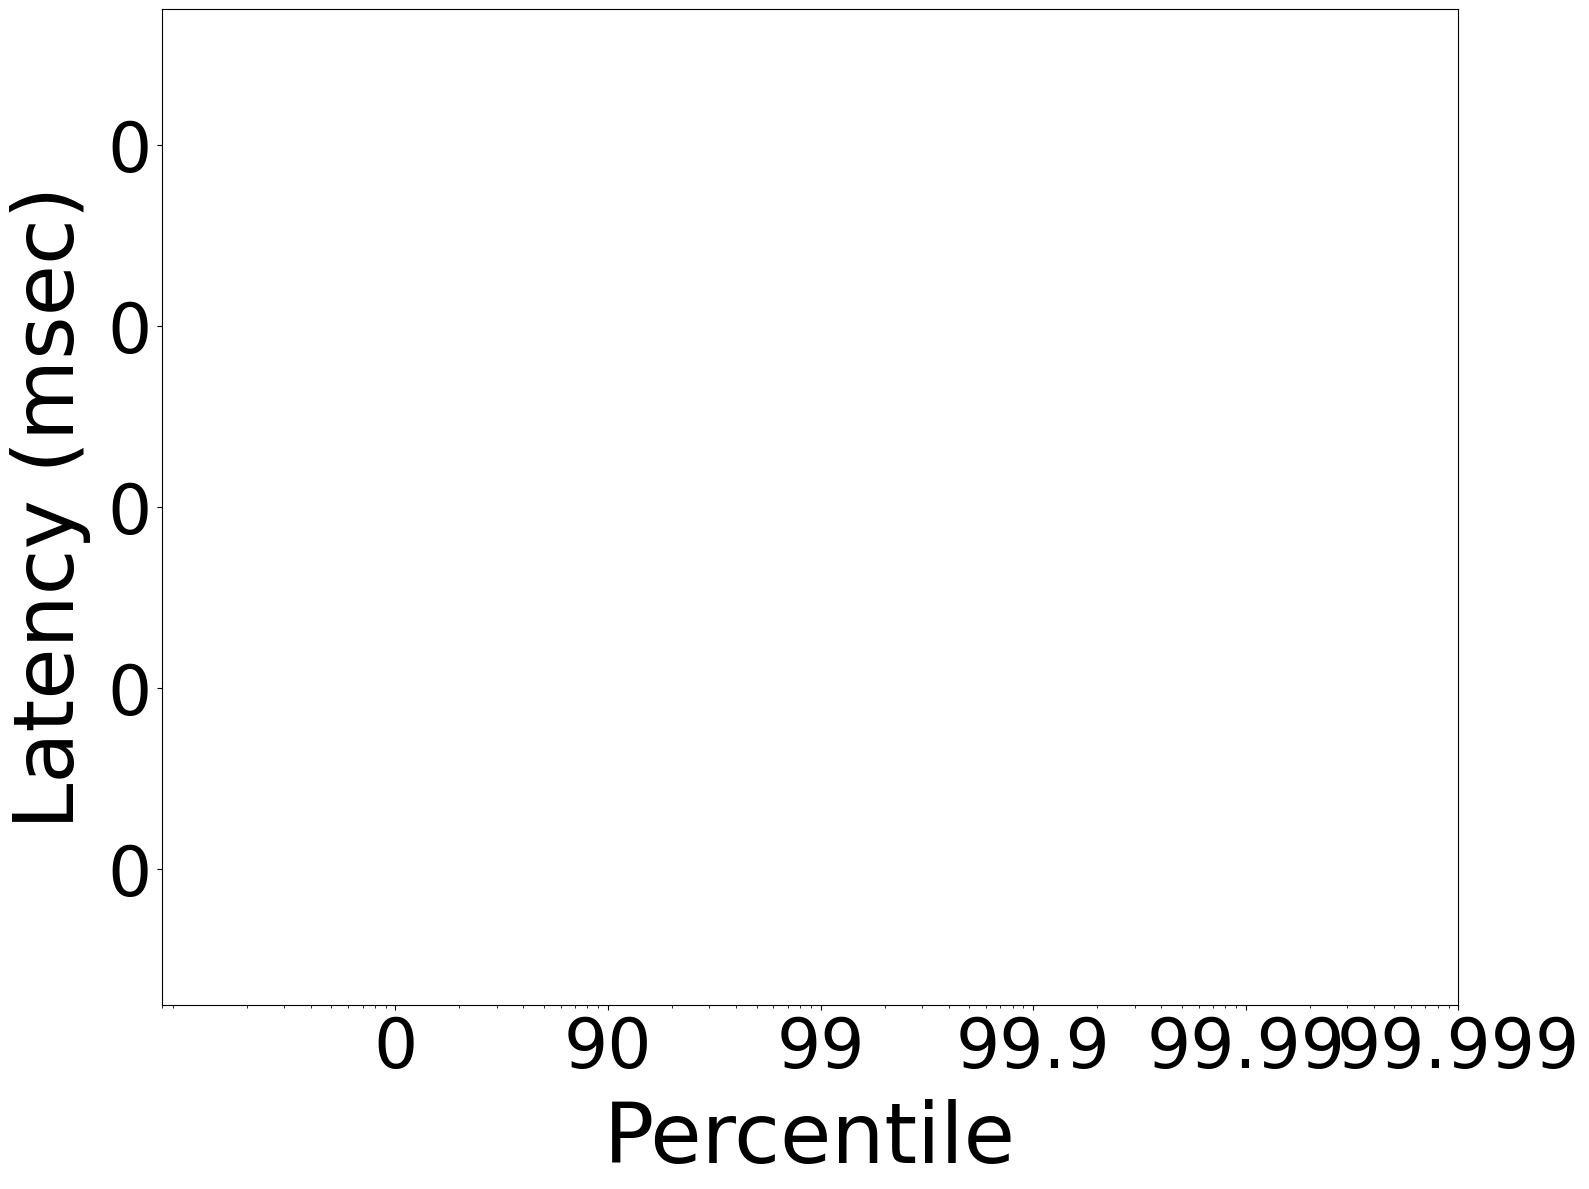

In [8]:
load_data_and_plot(bench='lusearch', legend=False)